# Восстановление золота из руды

Требуется подготовить прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Использовать будем данные с параметрами добычи и очистки.

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Требуется:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Данные находятся в трёх файлах:

gold_industry_train.csv — обучающая выборка; <br>
gold_industry_test.csv — тестовая выборка; <br>
gold_industry_full.csv — исходные данные. <br>

Данные индексируются датой и временем получения информации (признак date). Соседние по времени параметры часто похожи.
Некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей. Также в тестовом наборе нет целевых признаков.
Исходный датасет содержит обучающую и тестовую выборки со всеми признаками.

В нашем распоряжении сырые данные: их просто выгрузили из хранилища. Прежде чем приступить к построению модели, проверим их на корректность.

**Описание данных**

**Технологический процесс**

Rougher feed — исходное сырье

Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant

Xanthate — ксантогенат (промотер, или активатор флотации)

Sulphate — сульфат (на данном производстве сульфид натрия)

Depressant — депрессант (силикат натрия)

Rougher process (англ. «грубый процесс») — флотация

Rougher tails — отвальные хвосты

Float banks — флотационная установка

Cleaner process — очистка

Rougher Au — черновой концентрат золота

Final Au — финальный концентрат золота

**Параметры этапов**

air amount — объём воздуха

fluid levels — уровень жидкости

feed size — размер гранул сырья

feed rate — скорость подачи

**Наименование признаков**

Наименование признаков должно быть такое:

[*этап*].[*тип_параметра*].[*название_параметра*]

Пример: rougher.input.feed_ag

**Возможные значения для блока [этап]:**

rougher — флотация

primary_cleaner — первичная очистка

secondary_cleaner — вторичная очистка

final — финальные характеристики


**Возможные значения для блока [тип_параметра]:**

input — параметры сырья

output — параметры продукта

state — параметры, характеризующие текущее состояние этапа

calculation — расчётные характеристики

## Подготовка данных

**Задачи:**
- откроем файлы и изучим их
- проверим, что эффективность обогащения рассчитана правильно. Вычислим её на обучающей выборке для признака rougher.output.recovery и найдём MAE между нашими расчётами и значением признака
- проанализируем признаки, недоступные в тестовой выборке. Что это за параметры? К какому типу относятся?
- проведём предобработку данных

Загрузим нужные для работы библиотеки

In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats as stats
from scipy.stats import ttest_ind

from sklearn.model_selection import GridSearchCV, KFold  # подбор гиперпараметров
from sklearn.preprocessing import StandardScaler, RobustScaler  # алгоритм стандартизации данных
from sklearn.metrics import mean_absolute_error, make_scorer  # метрики
from sklearn.dummy import DummyRegressor  # константная модель
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings("ignore")

STATE = 12345

По условию у нас в распоряжении 3 набора данных:
- обучающая выборка
- тестовая выборка
- исходные данные (содержит обучающую и тестовую выборки со всеми признаками)

Будем загружать их и проводить предобработку по очереди. Начнем с исходных данных

In [ ]:
try:
    df_full = pd.read_csv('/datasets/gold_industry_full.csv')
except:
    df_full = pd.read_csv('https://code.s3.yandex.net/datasets/gold_industry_full.csv')

In [ ]:
def data_describe(data):
    print('Общая информация:')
    data.info()
    print('Первые 5 строк:')
    display(data.head())
    print('Описание датафрейма:')
    display(data.describe())
    print('Пропуски:')
    display(data.isnull().sum().sort_values(ascending=False))
    print('Дубликаты:')
    display(data.duplicated().sum())
    print('Уникальные значения:')
    display(data.nunique().sort_values())
    print('Разделим признаки на категориальные и числовые:')
    num_columns = []
    cat_columns = []
    for num, i in enumerate(data.columns):
        if pd.api.types.is_numeric_dtype(data[i]):
            num_columns.append(i)
        elif pd.api.types.is_object_dtype(data[i]):
            cat_columns.append(i)
    print('Всего числовых признаков:', len(num_columns))
    print('Всего категориальных признаков:', len(cat_columns))

Переведем дату и время в нужный временной формат

In [ ]:
df_full['date'] = pd.to_datetime(df_full['date'], format='%Y-%m-%d %H:%M:%S')

In [ ]:
data_describe(df_full)

Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   date                                                19439 non-null  datetime64[ns]
 1   rougher.input.feed_au                               19439 non-null  float64       
 2   rougher.input.feed_ag                               19439 non-null  float64       
 3   rougher.input.feed_pb                               19339 non-null  float64       
 4   rougher.input.feed_sol                              19340 non-null  float64       
 5   rougher.input.feed_rate                             19428 non-null  float64       
 6   rougher.input.feed_size                             19294 non-null  float64       
 7   rougher.input.floatbank10_sulfate                   19405 non-null  float64 

,date,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,...,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol
0,2016-01-15 00:00:00,6.486150,6.100378,2.284912,36.808594,523.546326,55.486599,11.986616,6.007990,999.706909,...,8.764648,42.192020,6.055403,9.889648,5.507324,70.541216,2.143149,10.411962,0.895447,16.904297
1,2016-01-15 01:00:00,6.478583,6.161113,2.266033,35.753385,525.290581,57.278666,11.971193,6.005766,1000.286398,...,9.001494,42.701629,6.029369,9.968944,5.257781,69.266198,2.224930,10.462676,0.927452,16.634514
2,2016-01-15 02:00:00,6.362222,6.116455,2.159622,35.971630,530.026610,57.510649,11.920603,6.197377,999.719565,...,8.842896,42.657501,6.055926,10.213995,5.383759,68.116445,2.257889,10.507046,0.953716,16.208849
3,2016-01-15 03:00:00,6.118189,6.043309,2.037807,36.862241,542.590390,57.792734,11.630094,6.203177,999.814770,...,9.122857,42.689819,6.047977,9.977019,4.858634,68.347543,2.146849,10.422762,0.883763,16.532835
4,2016-01-15 04:00:00,5.663707,6.060915,1.786875,34.347666,540.531893,56.047189,10.957755,6.198826,999.678690,...,8.871028,42.774141,6.148599,10.142511,4.939416,66.927016,2.055292,10.360302,0.792826,16.525686


Описание датафрейма:


,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,...,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol
count,19439.000000,19439.000000,19339.000000,19340.000000,19428.000000,19294.000000,19405.000000,19431.000000,19438.000000,19438.000000,...,17691.000000,19439.000000,19438.000000,19438.000000,19228.000000,19439.000000,19439.000000,19438.000000,19338.000000,19433.000000
mean,8.266097,8.794927,3.598085,36.695114,478.320042,58.970310,12.334373,6.021474,1105.315068,-376.610690,...,7.167247,44.076513,5.168470,9.978895,9.501224,67.050208,3.042467,9.688589,2.705795,10.583728
std,1.955092,1.936847,1.049486,5.145445,105.373758,21.634478,3.427317,1.127263,160.826798,93.909667,...,3.916079,5.129784,1.372348,1.669240,2.787537,10.125840,0.922808,2.328642,0.949077,2.868782
min,0.010000,0.010000,0.010000,0.010000,0.002986,0.046369,0.001083,0.000568,-0.042069,-657.949759,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.854384,7.237967,2.887280,34.207799,416.525453,47.435103,10.000362,5.398678,999.661867,-499.835165,...,3.845475,43.402215,4.251240,9.137262,7.722820,63.299712,2.461138,8.062878,2.040119,8.938947
50%,8.125839,8.593574,3.534895,37.202650,499.416120,54.610197,12.001174,6.008273,1001.072890,-300.263994,...,7.685827,45.011244,5.066094,10.102433,9.218961,68.172738,2.984909,9.743623,2.748730,10.622456
75%,9.769917,10.213771,4.244161,40.039133,550.172183,65.023044,14.716595,6.798051,1205.620588,-299.981998,...,10.411296,46.275313,5.895527,11.035769,10.947813,72.686642,3.571351,11.134294,3.333216,12.104271
max,13.731330,14.596026,7.142594,53.477742,717.508837,484.967466,36.118275,9.703448,1521.980372,-273.776101,...,26.000772,52.756638,16.001945,17.031899,19.615720,100.000000,8.245022,19.552149,5.804178,22.317730


Пропуски:


secondary_cleaner.output.tail_sol           1748
rougher.input.floatbank11_xanthate           453
rougher.state.floatbank10_e_air              436
primary_cleaner.output.concentrate_sol       370
secondary_cleaner.state.floatbank2_a_air     220
                                            ... 
rougher.output.tail_sol                        0
primary_cleaner.input.feed_size                0
rougher.input.feed_au                          0
primary_cleaner.output.concentrate_au          0
date                                           0
Length: 87, dtype: int64

Дубликаты:


0

Уникальные значения:


primary_cleaner.input.feed_size       5022
secondary_cleaner.output.tail_sol    16831
secondary_cleaner.output.tail_pb     18562
secondary_cleaner.output.tail_ag     18576
secondary_cleaner.output.tail_au     18578
                                     ...  
rougher.state.floatbank10_e_level    19439
rougher.state.floatbank10_d_level    19439
rougher.state.floatbank10_f_air      19439
rougher.state.floatbank10_d_air      19439
date                                 19439
Length: 87, dtype: int64

Разделим признаки на категориальные и числовые:
Всего числовых признаков: 86
Всего категориальных признаков: 0


- исходный датафрейм содержит 87 стобцов и 19439 строк
- присутствуют пропуски
- явные дубликаты не найдены
- существуют дубликаты по отдельным параметрам (неуникальные значения)
- все признаки числовые

Далее загрузим обучающую выборку

In [ ]:
try:
    df_train = pd.read_csv('/datasets/gold_industry_train.csv')
except:
    df_train = pd.read_csv('https://code.s3.yandex.net/datasets/gold_industry_train.csv')

In [ ]:
df_train['date'] = pd.to_datetime(df_train['date'], format='%Y-%m-%d %H:%M:%S')

In [ ]:
data_describe(df_train)

Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14579 entries, 0 to 14578
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   date                                                14579 non-null  datetime64[ns]
 1   rougher.input.feed_au                               14579 non-null  float64       
 2   rougher.input.feed_ag                               14579 non-null  float64       
 3   rougher.input.feed_pb                               14507 non-null  float64       
 4   rougher.input.feed_sol                              14502 non-null  float64       
 5   rougher.input.feed_rate                             14572 non-null  float64       
 6   rougher.input.feed_size                             14478 non-null  float64       
 7   rougher.input.floatbank10_sulfate                   14548 non-null  float64 

,date,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,...,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol
0,2016-01-15 00:00:00,6.486150,6.100378,2.284912,36.808594,523.546326,55.486599,11.986616,6.007990,999.706909,...,8.764648,42.192020,6.055403,9.889648,5.507324,70.541216,2.143149,10.411962,0.895447,16.904297
1,2016-01-15 01:00:00,6.478583,6.161113,2.266033,35.753385,525.290581,57.278666,11.971193,6.005766,1000.286398,...,9.001494,42.701629,6.029369,9.968944,5.257781,69.266198,2.224930,10.462676,0.927452,16.634514
2,2016-01-15 02:00:00,6.362222,6.116455,2.159622,35.971630,530.026610,57.510649,11.920603,6.197377,999.719565,...,8.842896,42.657501,6.055926,10.213995,5.383759,68.116445,2.257889,10.507046,0.953716,16.208849
3,2016-01-15 03:00:00,6.118189,6.043309,2.037807,36.862241,542.590390,57.792734,11.630094,6.203177,999.814770,...,9.122857,42.689819,6.047977,9.977019,4.858634,68.347543,2.146849,10.422762,0.883763,16.532835
4,2016-01-15 04:00:00,5.663707,6.060915,1.786875,34.347666,540.531893,56.047189,10.957755,6.198826,999.678690,...,8.871028,42.774141,6.148599,10.142511,4.939416,66.927016,2.055292,10.360302,0.792826,16.525686


Описание датафрейма:


,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,...,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol
count,14579.000000,14579.000000,14507.000000,14502.000000,14572.000000,14478.000000,14548.000000,14572.000000,14579.000000,14579.000000,...,13659.000000,14579.000000,14578.000000,14578.000000,14387.000000,14579.000000,14579.000000,14578.000000,14504.000000,14574.000000
mean,8.352941,8.877460,3.604221,36.561420,474.332784,58.922712,12.427399,5.994854,1104.208278,-379.367166,...,7.111347,43.979499,5.192145,9.923809,9.566676,66.759066,3.087939,9.731972,2.719985,10.612745
std,1.934376,1.922536,1.056063,5.209823,108.503552,22.407410,3.428939,1.152873,162.235606,94.652311,...,3.909951,5.471437,1.388014,1.706976,2.805654,10.619709,0.915187,2.358143,0.958929,2.871075
min,0.010000,0.010000,0.010000,0.010000,0.002986,0.049194,0.001083,0.000568,-0.042069,-657.949759,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.932996,7.341922,2.880490,34.093951,411.048483,47.278490,10.002832,5.304167,999.644856,-499.861797,...,3.784897,43.345906,4.283347,9.103183,7.860030,63.114596,2.505287,8.088928,2.036512,9.013412
50%,8.225284,8.715859,3.532399,37.097511,498.187968,54.361187,12.003320,6.003053,1000.982624,-300.314199,...,7.629968,44.975014,5.118647,10.046455,9.301970,67.962788,3.029238,9.818512,2.774847,10.670515
75%,9.832210,10.255843,4.257282,39.899799,549.586552,64.464926,14.929903,6.796632,1292.663971,-299.989315,...,10.367050,46.275153,5.925380,10.981203,11.001573,72.598187,3.614098,11.169187,3.353845,12.130827
max,13.731330,14.596026,7.052325,53.475325,717.508837,484.967466,36.118275,9.703448,1512.299531,-273.776101,...,26.000772,52.756638,16.001945,16.705297,19.423912,100.000000,8.245022,19.552149,5.804178,22.317730


Пропуски:


secondary_cleaner.output.tail_sol           920
rougher.state.floatbank10_e_air             429
rougher.input.floatbank11_xanthate          407
primary_cleaner.output.concentrate_sol      265
final.output.concentrate_sol                192
                                           ... 
primary_cleaner.state.floatbank8_c_air        0
primary_cleaner.state.floatbank8_c_level      0
primary_cleaner.state.floatbank8_d_level      0
primary_cleaner.output.concentrate_au         0
primary_cleaner.state.floatbank8_b_level      0
Length: 87, dtype: int64

Дубликаты:


0

Уникальные значения:


primary_cleaner.input.feed_size                3850
secondary_cleaner.output.tail_sol             12924
secondary_cleaner.output.tail_pb              13838
secondary_cleaner.output.tail_ag              13844
secondary_cleaner.output.tail_au              13845
                                              ...  
secondary_cleaner.state.floatbank2_a_level    14579
secondary_cleaner.state.floatbank2_b_level    14579
secondary_cleaner.state.floatbank3_a_level    14579
secondary_cleaner.state.floatbank4_a_level    14579
primary_cleaner.state.floatbank8_b_level      14579
Length: 87, dtype: int64

Разделим признаки на категориальные и числовые:
Всего числовых признаков: 86
Всего категориальных признаков: 0


- обучающая выборка содержит 87 стобцов и 14579 строк
- присутствуют пропуски
- явные дубликаты не найдены
- существуют дубликаты по отдельным параметрам (неуникальные значения)
- все признаки числовые

И загрузим тестовую выборку

In [ ]:
try:
    df_test = pd.read_csv('/datasets/gold_industry_test.csv')
except:
    df_test = pd.read_csv('https://code.s3.yandex.net/datasets/gold_industry_test.csv')

In [ ]:
df_test['date'] = pd.to_datetime(df_test['date'], format='%Y-%m-%d %H:%M:%S')

In [ ]:
data_describe(df_test)

Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4860 entries, 0 to 4859
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   date                                        4860 non-null   datetime64[ns]
 1   rougher.input.feed_au                       4860 non-null   float64       
 2   rougher.input.feed_ag                       4860 non-null   float64       
 3   rougher.input.feed_pb                       4832 non-null   float64       
 4   rougher.input.feed_sol                      4838 non-null   float64       
 5   rougher.input.feed_rate                     4856 non-null   float64       
 6   rougher.input.feed_size                     4816 non-null   float64       
 7   rougher.input.floatbank10_sulfate           4857 non-null   float64       
 8   rougher.input.floatbank10_xanthate          4859 non-null   float64   

,date,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2017-12-09 14:59:59,4.365491,6.158718,3.875727,39.135119,555.820208,94.544358,6.146982,9.308612,1196.238112,...,23.018622,-500.492702,20.020205,-500.220296,17.963512,-499.939490,12.990306,-500.080993,19.990336,-499.191575
1,2017-12-09 15:59:59,4.362781,6.048130,3.902537,39.713906,544.731687,123.742430,6.210119,9.297709,1201.904177,...,23.024963,-501.153409,20.054122,-500.314711,17.979515,-499.272871,12.992404,-499.976268,20.013986,-500.625471
2,2017-12-09 16:59:59,5.081681,6.082745,4.564078,37.208683,558.155110,82.610855,7.363824,9.003562,1200.826926,...,22.993827,-501.559663,20.029144,-500.000662,18.012723,-500.024764,13.016445,-500.058432,19.973767,-501.394155
3,2017-12-09 17:59:59,5.145949,6.084374,4.768124,36.808874,539.713765,77.984784,6.927072,8.955597,1199.292489,...,23.032807,-501.287889,19.977466,-500.159903,17.980463,-500.504602,12.949071,-500.009937,20.010332,-508.337973
4,2017-12-09 18:59:59,5.735249,6.165220,4.512346,37.810642,558.713584,86.434874,7.823471,7.490356,1198.005449,...,23.001911,-499.947838,20.023735,-499.713680,17.990955,-500.334769,13.007523,-499.968459,19.995999,-499.788805


Описание датафрейма:


,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,4860.000000,4860.000000,4832.000000,4838.000000,4856.000000,4816.000000,4857.000000,4859.000000,4859.000000,4859.000000,...,4.859000e+03,4859.000000,4.859000e+03,4859.000000,4859.000000,4859.000000,4859.000000,4859.000000,4859.000000,4859.000000
mean,8.005584,8.547348,3.579662,37.095864,490.285103,59.113400,12.055735,6.101308,1108.635895,-368.340127,...,1.985770e+01,-488.665140,1.557025e+01,-464.176507,16.594103,-490.815250,12.945971,-489.583564,19.053888,-504.678924
std,1.993590,1.958601,1.029377,4.926284,94.371623,19.125122,3.407642,1.042754,156.493143,91.155929,...,5.913105e+00,44.392714,4.927361e+00,65.706994,5.724305,32.258443,5.533176,37.084609,5.548996,38.690186
min,0.010000,0.010000,0.010000,0.010000,0.012786,0.046369,0.018907,0.015783,300.792494,-600.568138,...,1.079872e-16,-799.704969,2.489718e-17,-799.860767,-0.371498,-797.142475,1.358469,-800.006180,0.160386,-809.734800
25%,6.574363,6.975898,2.903612,34.510841,434.099695,47.596984,9.890429,5.499808,999.715729,-499.731972,...,1.501123e+01,-500.704004,1.202172e+01,-500.196517,11.073822,-500.483564,9.011890,-500.129913,14.963953,-500.668501
50%,7.812923,8.179714,3.540772,37.499761,502.118742,55.509481,11.997859,6.099805,1001.414798,-300.181367,...,1.996807e+01,-499.892919,1.501240e+01,-499.540776,16.631195,-499.873136,11.999417,-499.955304,19.960006,-500.033769
75%,9.556589,10.084339,4.199847,40.461315,555.596563,66.661547,14.496072,6.802101,1202.837565,-299.961547,...,2.498900e+01,-498.652030,1.999949e+01,-400.302329,19.983191,-498.852815,15.004198,-499.643776,24.974583,-499.460134
max,13.417156,14.533698,7.142594,53.477742,702.523396,363.989699,30.010759,9.396928,1521.980372,-281.039299,...,3.008450e+01,-383.373053,2.398898e+01,-114.250832,33.215996,-288.963521,24.177106,-141.934397,32.028529,-104.427459


Пропуски:


secondary_cleaner.state.floatbank2_a_air      126
rougher.input.floatbank11_xanthate             46
rougher.input.feed_size                        44
primary_cleaner.input.xanthate                 43
rougher.input.feed_pb                          28
rougher.input.feed_sol                         22
primary_cleaner.input.depressant                9
rougher.input.floatbank11_sulfate               8
rougher.state.floatbank10_e_air                 7
rougher.input.feed_rate                         4
rougher.input.floatbank10_sulfate               3
primary_cleaner.state.floatbank8_d_air          2
primary_cleaner.state.floatbank8_c_air          2
primary_cleaner.state.floatbank8_d_level        1
secondary_cleaner.state.floatbank3_a_level      1
secondary_cleaner.state.floatbank2_a_level      1
secondary_cleaner.state.floatbank2_b_air        1
secondary_cleaner.state.floatbank2_b_level      1
secondary_cleaner.state.floatbank3_a_air        1
secondary_cleaner.state.floatbank4_a_air        1


Дубликаты:


0

Уникальные значения:


primary_cleaner.input.feed_size               1448
secondary_cleaner.state.floatbank2_a_air      4734
rougher.input.floatbank11_xanthate            4810
rougher.input.feed_size                       4811
primary_cleaner.input.xanthate                4817
rougher.input.feed_pb                         4827
secondary_cleaner.state.floatbank2_b_air      4829
secondary_cleaner.state.floatbank3_b_air      4831
rougher.input.feed_sol                        4834
secondary_cleaner.state.floatbank3_a_air      4844
primary_cleaner.input.depressant              4851
rougher.input.floatbank11_sulfate             4852
secondary_cleaner.state.floatbank4_b_air      4852
rougher.state.floatbank10_e_air               4853
secondary_cleaner.state.floatbank4_a_air      4855
rougher.input.feed_rate                       4856
rougher.input.feed_au                         4857
rougher.input.feed_ag                         4857
rougher.input.floatbank10_sulfate             4857
primary_cleaner.state.floatbank

Разделим признаки на категориальные и числовые:
Всего числовых признаков: 52
Всего категориальных признаков: 0


- тестовая выборка содержит 53 столбца и 4860 строк
- присутствуют пропуски
- явные дубликаты не найдены
- существуют дубликаты по отдельным параметрам (неуникальные значения)
- все признаки числовые

Итого:

In [ ]:
print('Исходные данные:', df_full.shape)
print('Тренировочная выборка:', df_train.shape)
print('Тестовая выборка:', df_test.shape)
print('Тренировочная + тестовая выборки:', df_train.shape[0] + df_test.shape[0])

Исходные данные: (19439, 87)
Тренировочная выборка: (14579, 87)
Тестовая выборка: (4860, 53)
Тренировочная + тестовая выборки: 19439


- суммарно количество строк в тренировочной и тестовой выборке равно количеству строк в исходных данных
- в тестовой выборке отстутвует часть столбцов, что соответствует условиям (некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые есть в обучающей). Также в тестовом наборе нет целевых признаков

Визуализируем данные во времени

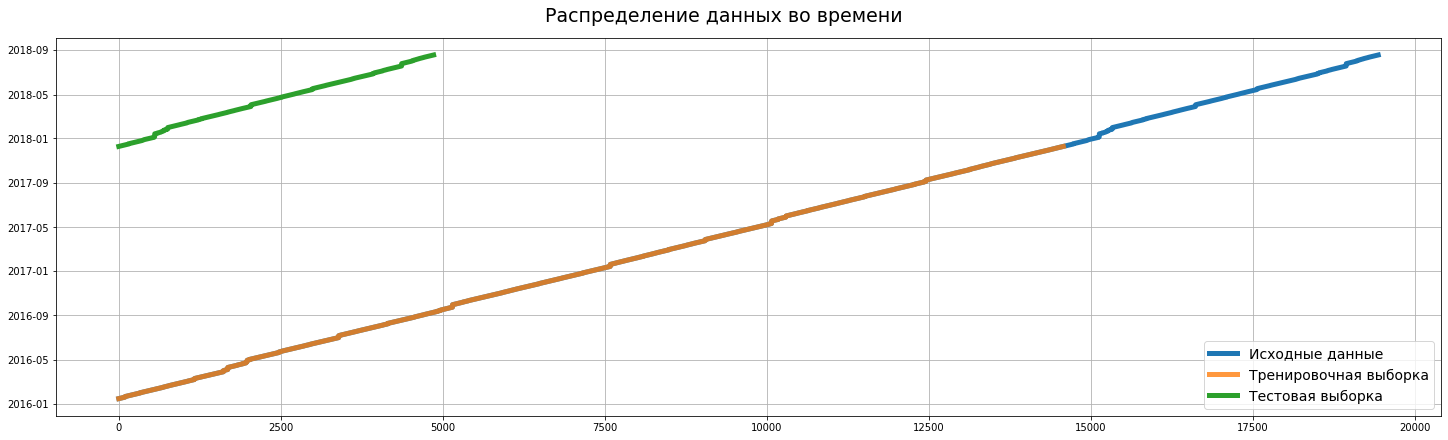

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20,6), constrained_layout=True)
fig.suptitle('Распределение данных во времени', fontsize=19)

ax.plot(df_full['date'], linewidth=5)
ax.plot(df_train['date'], alpha=0.8, linewidth=5)
ax.plot(df_test['date'], linewidth=5)
plt.grid(True)

ax.legend(['Исходные данные', 'Тренировочная выборка', 'Тестовая выборка'], fontsize=14)

plt.show();

Из графика мы видим, что в каждой выборке данные распределены равномерно. Данные в тестовой выборке начинаются с конца 2017 года

Проверим, что эффективность обогащения рассчитана правильно. Вычислим её на обучающей выборке для признака rougher.output.recovery и найдём MAE между нашими расчётами и значением признака

Эффективность обогащения рассчитаем по формуле: (C(F-T)/F(C-T))*100, где:

C — доля золота в концентрате после флотации/очистки

F — доля золота в сырье/концентрате до флотации/очистки

T — доля золота в отвальных хвостах после флотации/очистки


Напишем функцию:

In [ ]:
def enrichment_efficiency(c, f, t):
    return (c*(f-t))/(f*(c-t))*100

In [ ]:
recovery_train = enrichment_efficiency(
        df_train['rougher.output.concentrate_au'],
        df_train['rougher.input.feed_au'],
        df_train['rougher.output.tail_au']
)

count_correct_predictions = np.isclose(recovery_train, df_train['rougher.output.recovery']).sum()
print('Количество верных предсказаний:', count_correct_predictions)
print('Количество неверных предсказаний:', df_train.shape[0] - count_correct_predictions)
print('MAE:', mean_absolute_error(df_train['rougher.output.recovery'], recovery_train))

Количество верных предсказаний: 14579
Количество неверных предсказаний: 0
MAE: 9.83758577644259e-15


Итого мы видим, что средняя абсолютная ошибка между нашими расчётами и значением признака ничтожно мала. Таким образом, расчеты мы можем считать верными и эффективность обогащения рассчитана правильно

Далее проанализируем признаки, недоступные в тестовой выборке. Что это за параметры? К какому типу относятся?

In [ ]:
missing_features = [name for name in df_train.columns if name not in df_test.columns]
print('Количество признаков, недоступных в тестовой выборке:', len(missing_features))
print('Признаки, недоступные в тестовой выборке:')
missing_features

Количество признаков, недоступных в тестовой выборке: 34
Признаки, недоступные в тестовой выборке:


['rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_au',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.tail_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'secondary_cleaner.output.tail_au',
 'secondary_cleaner.output.tail_ag',
 'secondary_cleaner.output.tail_pb',
 'secondary_cleaner.output.tail_sol',
 'final.output.concentrate_au',
 'final.output.concentrate_ag',
 'final

Всего в тестовой выборке отсутствует 34 признака. Среди них:

Этапы:
- присутствует каждый этап из 4-х возможных:
    - 13 признаков этапа флотации (rougher)
    - 8 признаков этапа первичной очистки (primary_cleaner)
    - 4 признака этапа вторичной очистки (secondary_cleaner)
    - 9 признаков финальных характеристик (final)
    
Типы параметров:
- 4 признака признака с расчетными характеристиками `calculation` (все относятся к этапу флотации (rougher))
- 30 признаков этапа параметров продукта `output`


- отсутствуют целевые признаки - rougher.output.recovery и final.output.recovery
- на всех этапах отсутствует информация о хвостовых частях
- кроме повторной очистки на всех этапах отсутствует информация о концентрации металлов

Далее проведём предобработку данных. Начнём с заполнения пропусков

По условию соседние по времени параметры часто похожи, поэтому для заполнения пропусков используем метод `ffill`

In [ ]:
df_full = df_full.fillna(method='ffill')
df_train = df_train.fillna(method='ffill')
df_test = df_test.fillna(method='ffill')

print('Количество пропусков в исходных данных:', df_full.isnull().sum().sum())
print('Количество пропусков в тренировочной выборке:', df_train.isnull().sum().sum())
print('Количество пропусков в тестовой выборке:', df_test.isnull().sum().sum())

Количество пропусков в исходных данных: 0
Количество пропусков в тренировочной выборке: 0
Количество пропусков в тестовой выборке: 0


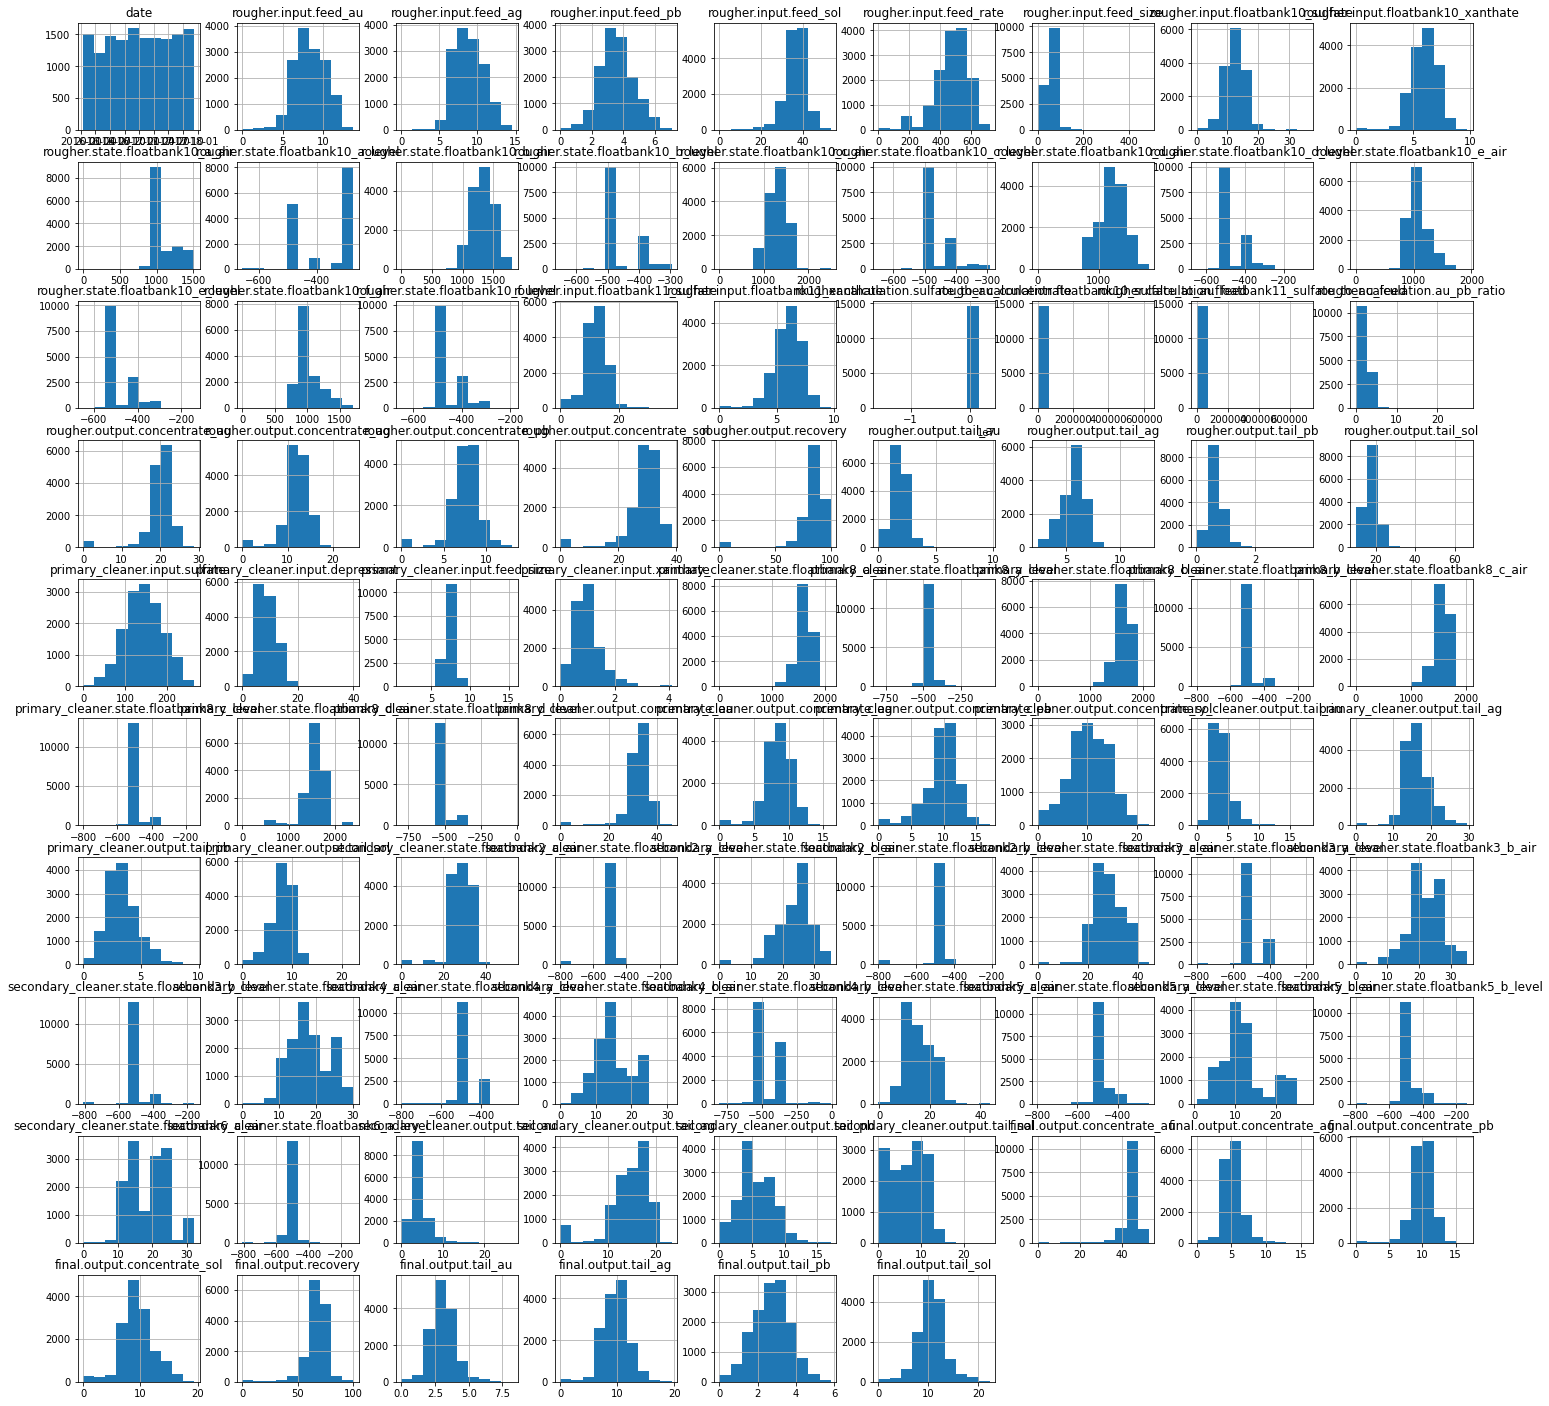

In [ ]:
df_train.hist(figsize=(25, 25));

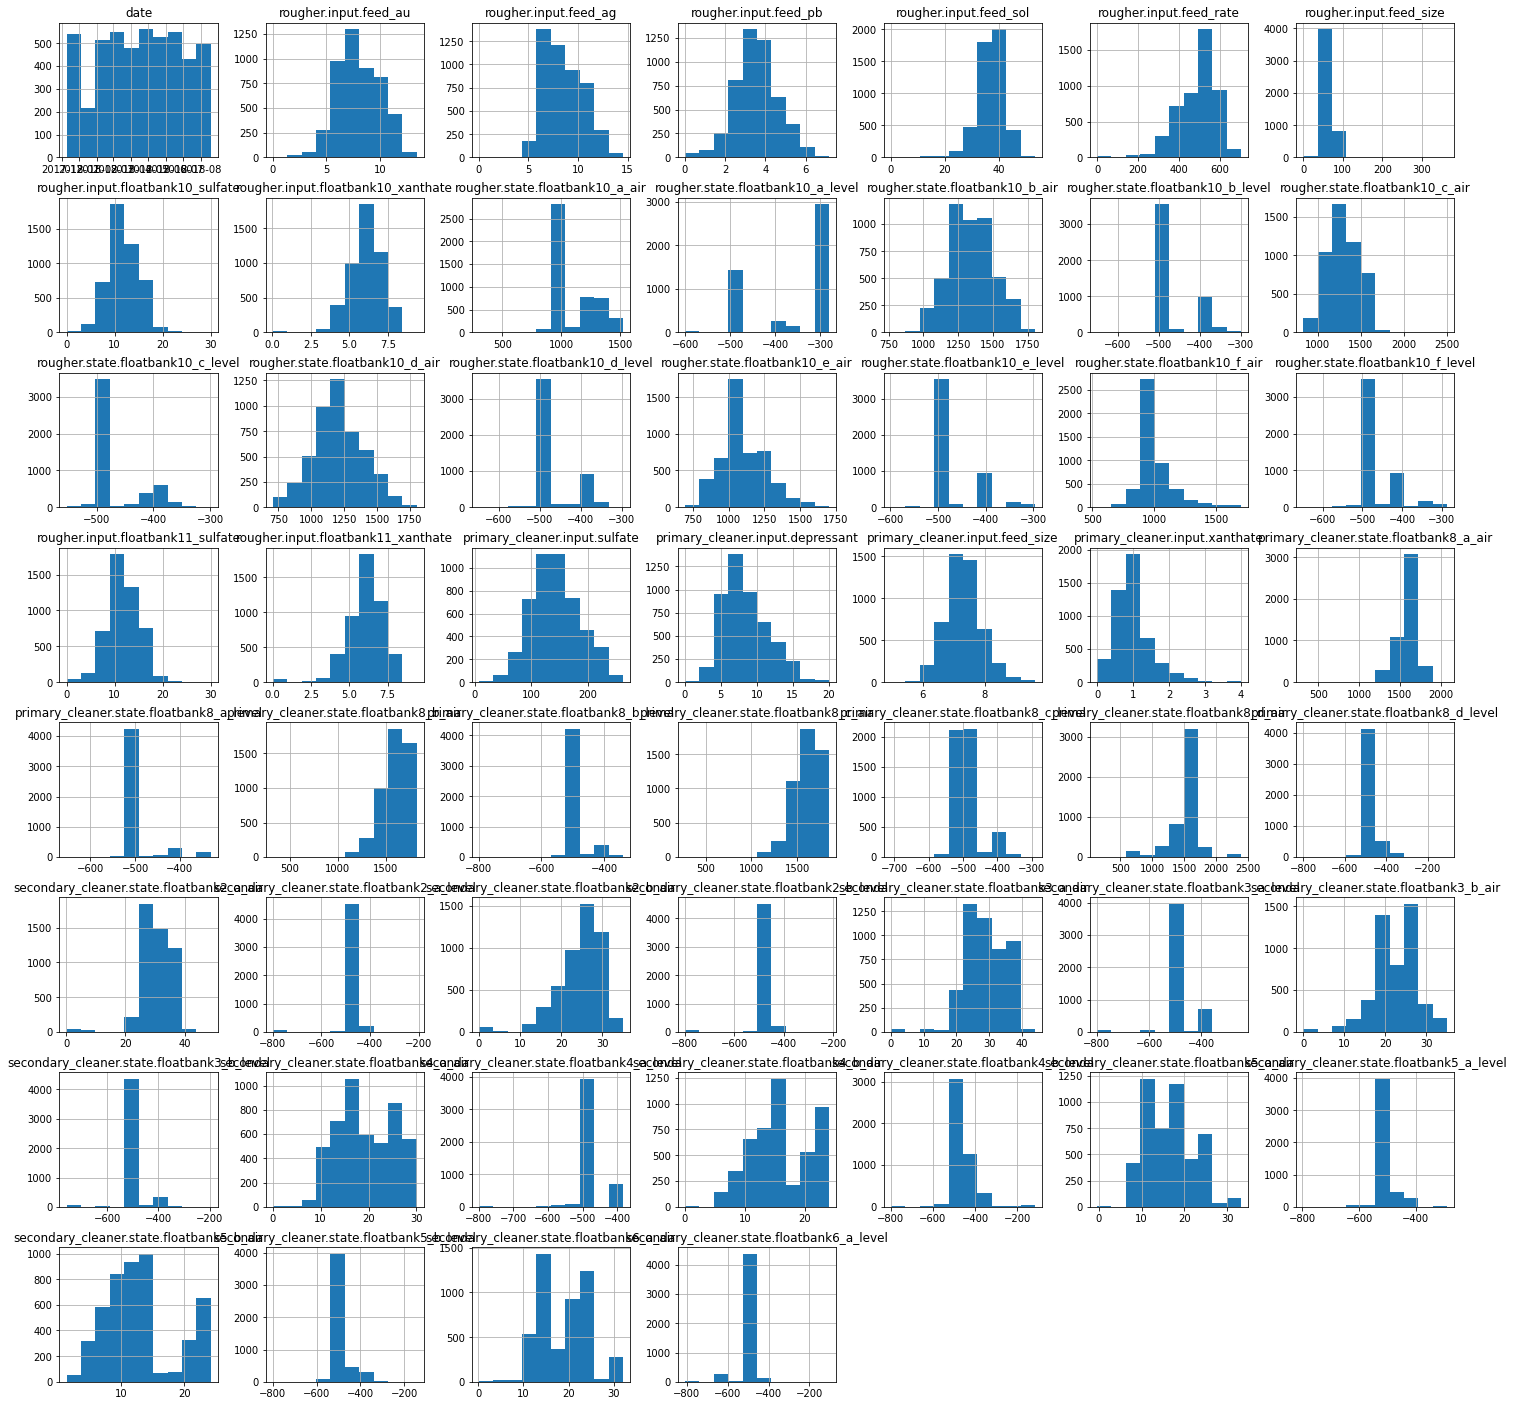

In [ ]:
df_test.hist(figsize=(25, 25));

**Выводы по этапу подготовки данных:**

- загружены исходный датафрейм, тренировочная и тестовая выборки
- дата переведена в нужный формат времени
- все признаки числовые
- во всех наборах данных обраружены и обработаны пропуски
- во всех наборах данных явные дубликаты не найдены, найдены дубликаты по отдельным параметрам (неуникальные значения)
- определили, что во всех наборах данных данные распределены равномерно
- проверили, что эффективность обогащения рассчитана правильно (поиском MAE между значением признака и нашими расчетами)
- проанализировали признаки, недоступные в тестовой выборке - отсутствует 34 признака (предположительно, это может быть связанно с тем, что они вычисляются позже по технологическому процессу восстановления золота)

## Анализ данных

**Задачи:**
- посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах: в сырье, в черновом концентрате, в концентрате после первой очистки и в финальном концентрате. Какие особенности имеют распределения?
- сравним распределения размеров гранул исходного сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной
- исследуем суммарную концентрацию металлов на разных стадиях: в сырье, в черновом концентрате, в концентрате после первой очистки и в финальном концентрате

- определим списки металлов (Au, Ag, Pb) и этапов (сырье, черновой концентрат, концентрат после первой очистки, финальный концентрат)
- определим особенности распределения

In [ ]:
metals = ['au', 'ag', 'pb']

stages = ['rougher.input.feed_', 'rougher.output.concentrate_',
                      'primary_cleaner.output.concentrate_', 'final.output.concentrate_']

names_stages = ['сырье', 'черновой концентрат', 'концентрат после первой очистки', 'финальный концентрат']

Построим графики

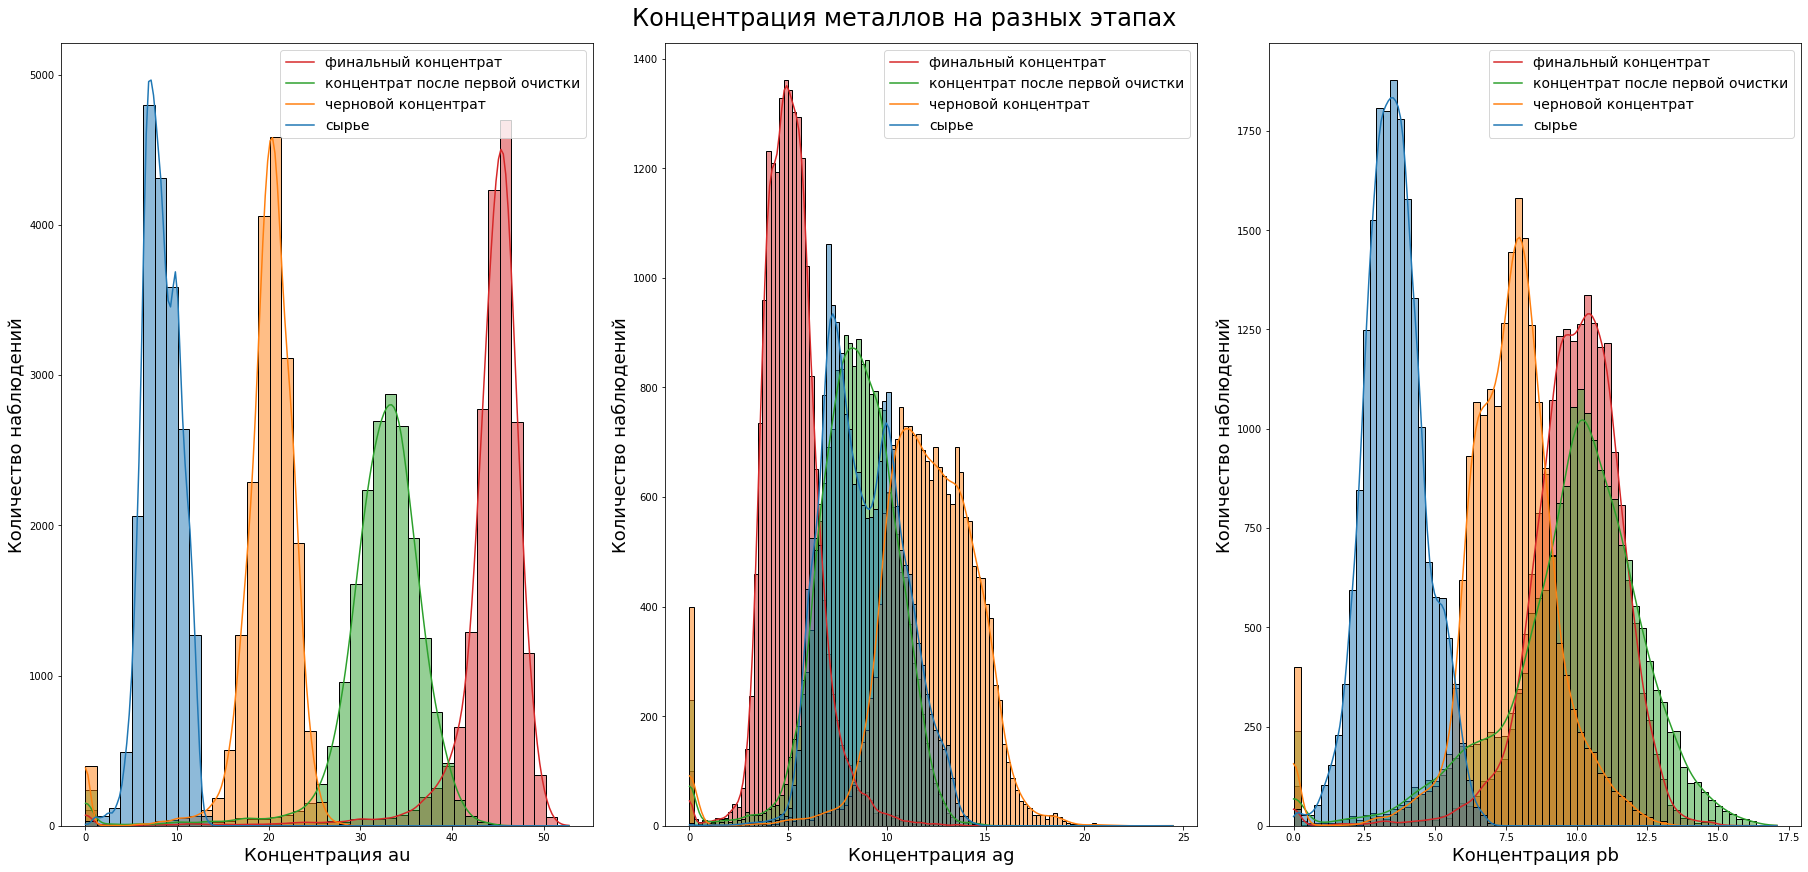

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(25,12), constrained_layout=True)
fig.suptitle('Концентрация металлов на разных этапах', fontsize=24)

for metal, ax, name in zip(metals, axs, names_stages):
    current_stage_name = [stage + metal for stage in stages]
    sns.histplot(df_full[current_stage_name],
                 label=current_stage_name, ax=ax,
                 kde=True, linewidth=1)
    ax.legend(['финальный концентрат', 'концентрат после первой очистки',
               'черновой концентрат', 'сырье'], fontsize=14)
    ax.set_xlabel('Концентрация ' + metal, fontsize=18)
    ax.set_ylabel('Количество наблюдений', fontsize=18)

plt.show();

**Выводы по гистограммам (особенности распределения):**

- концентрация золота увеличивается после каждого этапа очистки до максимальной концентрации на 4-м этапе
- концентрация серебра увеличивается от сырья до чернового концентрата, а после очистки постепенно уменьшается до значений ниже изначального сырья
- концентрация свинца увеличивается на первых 3-х этапах, а на 4-м этапе значения концентрации не превосходят значений концетрата после первой очистки - это, например, может говорить о неэффективном процессе очистки
- у всех металлов наблюдаем аномальные значения около нуля - они могли появиться по причине сбоя оборудования при фиксации значений концентраций, сбоя в технологическом процессе, некорректной выгрузки данных, человеческого фактора и ошибок сотрудников. Эти значения могут негативно повлиять на качество обучения модели, поэтому удалим их
- об особенностях распределения концентрации серебра, свинца и наличии близких к нулю значений стоит сообщить компании "Цифры"

Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки в отвальных хвостах. Определим этапы

In [ ]:
tail_stages = [col for col in df_full.columns if 'tail_' in col and any(i in col for i in ['au', 'ag', 'pb'])]
tail_stages

['rougher.output.tail_au',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'secondary_cleaner.output.tail_au',
 'secondary_cleaner.output.tail_ag',
 'secondary_cleaner.output.tail_pb',
 'final.output.tail_au',
 'final.output.tail_ag',
 'final.output.tail_pb']

- rougher.output.tail - концентрация металлов в хвостах после флотации
- primary_cleaner.output.tail - концентрация металлов в хвостах после первичной обработки
- secondary_cleaner.output.tail - концентрация металлов в хвостах после вторичной обработки
- final.output.tail - концентрация металлов в хвостах на финальном этапе

In [ ]:
tail_stages = ['rougher.output.tail_', 'primary_cleaner.output.tail_',
                      'secondary_cleaner.output.tail_', 'final.output.tail_']
names_tail_stages = ['хвосты после флотации', 'хвосты после первичной обработки', 'хвосты после вторичной обработки',
                     'хвосты на финальном этапе']

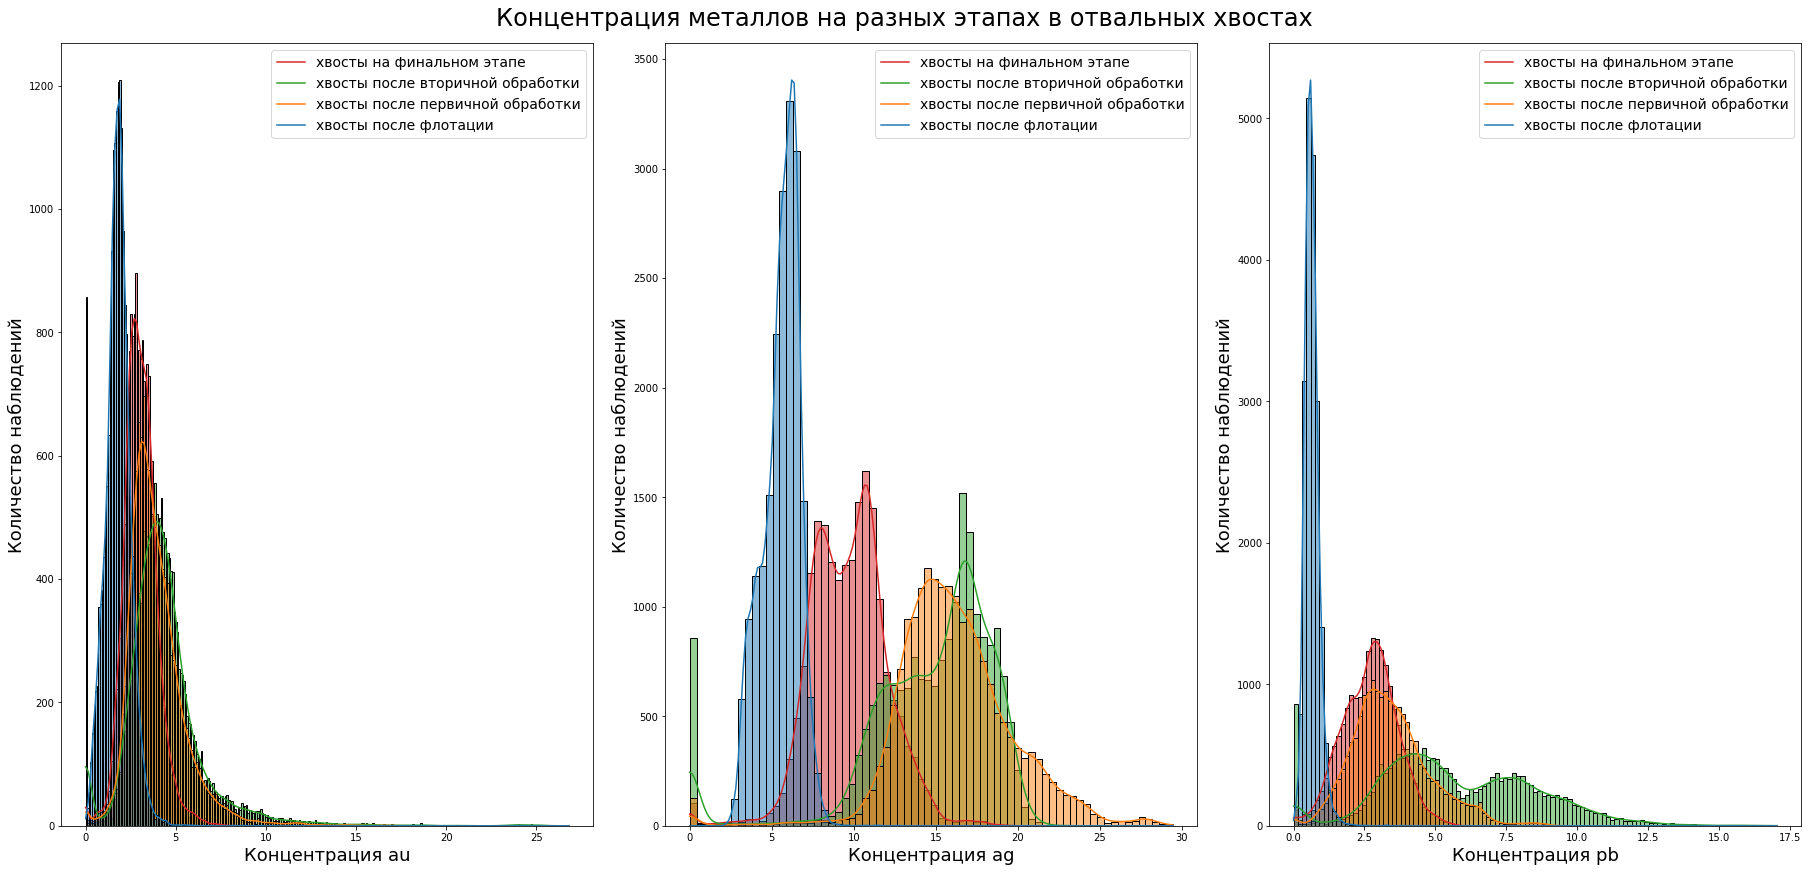

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(25,12), constrained_layout=True)
fig.suptitle('Концентрация металлов на разных этапах в отвальных хвостах', fontsize=24)

for metal, ax, name in zip(metals, axs, names_tail_stages):
    current_tail_stage_name = [stage + metal for stage in tail_stages]
    sns.histplot(df_full[current_tail_stage_name],
                 label=current_tail_stage_name, ax=ax,
                 kde=True, linewidth=1)
    ax.legend(['хвосты на финальном этапе', 'хвосты после вторичной обработки',
               'хвосты после первичной обработки', 'хвосты после флотации'], fontsize=14)
    ax.set_xlabel('Концентрация ' + metal, fontsize=18)
    ax.set_ylabel('Количество наблюдений', fontsize=18)

plt.show();

**Выводы по гистограммам (особенности распределения):**

- по всем металлам наблюдается тенденция к снижению концентрации на финальном этапе после 2-х этапов обработки
- о достаточно большом количестве металлов, остающихся в отвальных хвостах стоит сообщить компании, так как, возможно, имеет место какая-то технологическая погрешность в обрабоке руды. Есть предположение, что качество руды может различаться в разных месторождениях, а для её обработки применяется какой-то константный метод и стоит его пересмотреть в зависимости от характеристик конкретного месторождения

- сравним распределения размеров гранул исходного сырья на обучающей и тестовой выборках (если распределения сильно отличаются друг от друга, оценка модели будет неправильной)

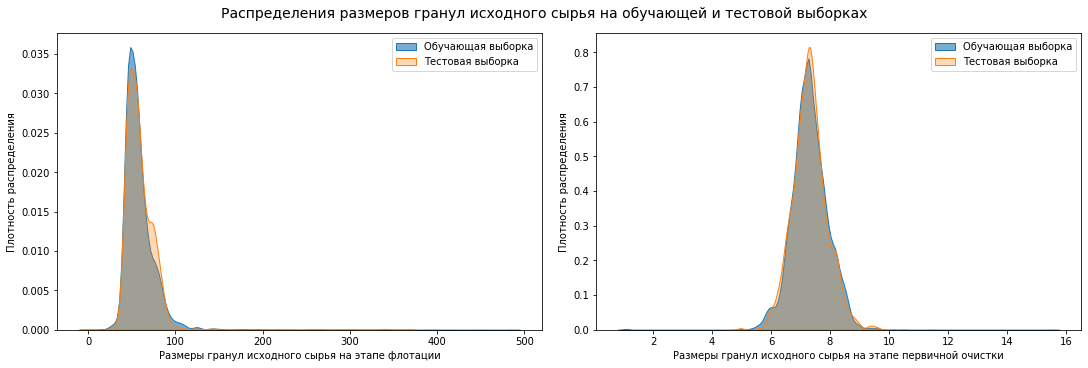

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15,5), constrained_layout=True)
fig.suptitle('Распределения размеров гранул исходного сырья на обучающей и тестовой выборках', fontsize=14)

sns.kdeplot(df_train['rougher.input.feed_size'], alpha=0.6, label='Обучающая выборка', shade=True, ax=axs[0])
sns.kdeplot(df_test['rougher.input.feed_size'], alpha=0.3, label='Тестовая выборка', shade=True, ax=axs[0])
axs[0].set_xlabel('Размеры гранул исходного сырья на этапе флотации')
axs[0].set_ylabel('Плотность распределения')
axs[0].legend()

sns.kdeplot(df_train['primary_cleaner.input.feed_size'], alpha=0.6, label='Обучающая выборка', shade=True, ax=axs[1])
sns.kdeplot(df_test['primary_cleaner.input.feed_size'], alpha=0.3, label='Тестовая выборка', shade=True, ax=axs[1])
axs[1].set_xlabel('Размеры гранул исходного сырья на этапе первичной очистки')
axs[1].set_ylabel('Плотность распределения')
axs[1].legend();

Сравним распределение признаков при помощи t-теста

In [ ]:
# на этапе флотации
t_1, p_value_1 = ttest_ind(df_train['rougher.input.feed_size'], df_test['rougher.input.feed_size'], equal_var= False)
# на этапе первичной очистки
t_2, p_value_2 = ttest_ind(df_train['primary_cleaner.input.feed_size'], df_test['primary_cleaner.input.feed_size'], equal_var= False)

alpha = 0.05 # уровень статистической значимости

if p_value_1 < alpha:
    print('p-value на этапе флотации (rougher.input.feed_size):', p_value_1, '==> Распределения различаются')
else:
    print('p-value на этапе флотации (rougher.input.feed_size):', p_value_1, '==> Распределения не различаются')

if p_value_2 < alpha:
    print('p-value на этапе первичной очистки (primary_cleaner.input.feed_size):', p_value_2, '==> Распределения различаются')
else:
    print('p-value на этапе первичной очистки (primary_cleaner.input.feed_size):', p_value_2, '==> Распределения не различаются')

p-value на этапе флотации (rougher.input.feed_size): 0.8468970428326675 ==> Распределения не различаются
p-value на этапе первичной очистки (primary_cleaner.input.feed_size): 0.8329712444062115 ==> Распределения не различаются


Можем сделать вывод, что распределения данных о размерах гранул исходного сырья на обучающей и тестовой выборках и на эпате флортации, и на этапе первичной очистки не различаются

Далее исследуем суммарную концентрацию металлов на разных стадиях: в сырье, в черновом концентрате, в концентрате после первой очистки и в финальном концентрате

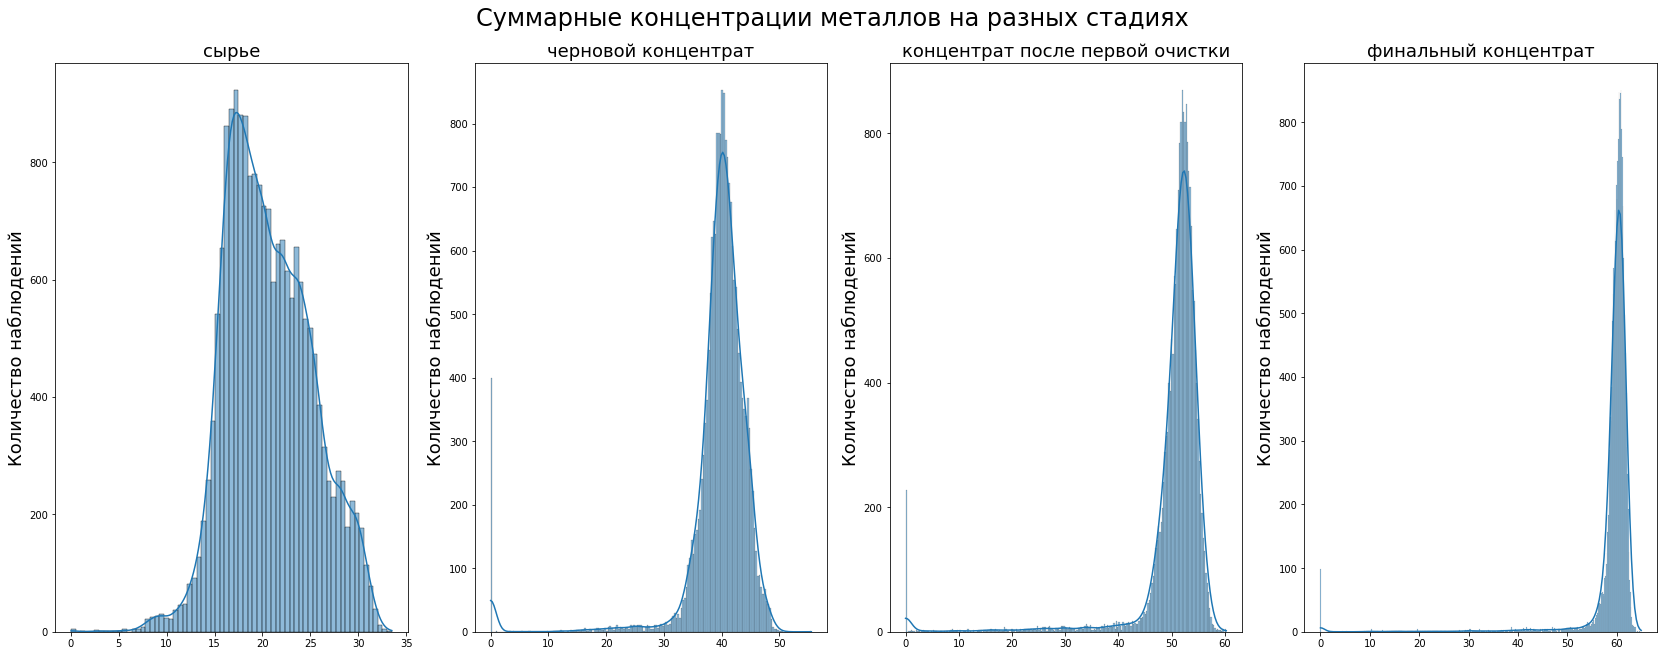

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(23,9), constrained_layout=True)
fig.suptitle('Cуммарные концентрации металлов на разных стадиях', fontsize=24)

for stage, ax, name in zip(stages, axs, names_stages):
    sns.histplot(df_full[stage + 'ag'] + df_full[stage + 'au'] + df_full[stage + 'pb'],
                 label='full', ax=ax, kde=True)
    ax.set_title(name, fontsize=18)
    ax.set_ylabel('Количество наблюдений', fontsize=18)

plt.show();

**Выводы по гистограммам (особенности распределения):**
- суммарная концентрация металлов увеличивается от этапа к этапу, максимальная - на этапе финального концентрата
- сужается ширина распределения суммарной концентрации металлов
- при этом мы видим и значения в нуле, и длинные хвосты выбросов. Длинные хвосты выбросов в распределениях могут указывать на наличие аномалий в данных. В случае производственного цикла обработки руды, когда мы имеем дело с реальными данными, подобные выбросы могут являться результатом естественных процессов, связанных с особенностями производства.

Нули могут указывать на пустую породу, в которой нет необходимой концентрации руды, а минимальные значения могли остаться после процесса обогащения. Нельзя исключать и ранее выдвинутую версию о том, что природа подобых хвостов может заключаться в технических сбоях работы датчиков фиксации значений концентраций или сбоях в технологическом процессе

Нулевые и около нулевые значения концентраций всех металлов - это явная аномалия. Скорее всего это связано со сбоем измерительного оборудования. Такие наблюдения нужно удалить из обучающих данных.
Модель планируется использовать для подбора параметров оборудования, поэтому примеры со сбоями не интересны для моделирования

In [ ]:
df_train.shape

(14579, 87)

In [ ]:
df_train = df_train[(df_train['rougher.input.feed_au'] != 0) &
                    (df_train['rougher.input.feed_ag'] != 0) &
                    (df_train['rougher.input.feed_pb'] != 0) &
                    (df_train['rougher.output.concentrate_au'] != 0) &
                    (df_train['rougher.output.concentrate_ag'] != 0) &
                    (df_train['rougher.output.concentrate_pb'] != 0) &
                    (df_train['primary_cleaner.output.concentrate_au'] != 0) &
                    (df_train['primary_cleaner.output.concentrate_ag'] != 0) &
                    (df_train['primary_cleaner.output.concentrate_pb'] != 0) &
                    (df_train['final.output.concentrate_au'] != 0) &
                    (df_train['final.output.concentrate_ag'] != 0) &
                    (df_train['final.output.concentrate_pb'] != 0)]

In [ ]:
df_train.shape

(13982, 87)

**Выводы по эпату анализа данных:**

- проведён исследовательский анализ данных
- изучили, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах технологического процесса
- обнаружили нули в распределениях изменений концентрации металлов, выдвинули несколько гипотез относительно их природы. Удалили аномальные значения для улучшения качества будущих моделей прогнозирования
- сравнили распределения размеров гранул исходного сырья на обучающей и тестовой выборках визуально и статистически с помощью t-теста для определения равенства средних значений двух независимых выборок с уровнем значимости 𝛼=5%. Обнаружили, что с большой долей вероятности распределения размеров гранул сырья на обучающей и тестовой выборках не имеют статистически значимых отличий, а значит этот признак пригоден для ML-моделей
- исследовали суммарную концентрацию металлов на разных стадиях технологического процесса и пришли к выводу, что она увеличивается к финальному этапу. Отдельно отметили, что в суммарной концентрации сырья имеются и значения в нуле, и длинные хвосты выбросов

В целом данные исследованы, изучены особенности, пропуски обработаны. Можем переходить к этапу моделирования

## Модель

**Задачи:**
- напишем функцию для вычисления итоговой sMAPE
- обучим разные модели и оценим их качество кросс-валидацией. Выберем лучшую модель и проверим её на тестовой выборке

В нашем исследовании будем сравнивать эффективность двух моделей регрессии:
- `LinearRegression`
- `RandomForestRegressor`

Выбор обусловлен тем, что использование более сложных алгоритмов вряд ли кардинально улучшит качество предсказаний.

Для решения задачи введём новую метрику качества — sMAPE (англ. Symmetric Mean Absolute Percentage Error, «симметричное среднее абсолютное процентное отклонение»).
Она похожа на MAE, но выражается не в абсолютных величинах, а в относительных.
Симметричная - потому что она одинаково учитывает масштаб и целевого признака, и предсказания.
Метрика sMAPE вычисляется так:

target - целевой признак (значение целевого признака для объекта с порядковым номером i в выборке, на которой измеряется качество) <br>
predictions - предсказание (значение предсказания для объекта с порядковым номером i, например, в тестовой выборке) <br>

И поскольку целевых признаков два, требуется ввести еще одну метрику - `final sMAPE`. По сути, в ней просто обобщим `sMAPE` для двух признаков в зависимости от важности их прогнозирования

In [ ]:
def smape(target, predictions):
    fraction = np.divide(np.abs(target - predictions), (np.abs(target) + np.abs(predictions)) / 2)
    value = np.average(fraction[((np.abs(target) + np.abs(predictions)) / 2) != 0], axis=0)
    return value * 100

def final_smape(rougher_smape, cleaner_smape):
    return 0.25 * rougher_smape + 0.75 * cleaner_smape

SCORER = make_scorer(smape, greater_is_better=False)

- обучим разные модели и оценим их качество кросс-валидацией. Выберем лучшую модель и проверим её на тестовой выборке

Посмотрим на наши таргеты:

`rougher.output.recovery` - эффективность обогащения чернового концентрата в результате флотации. Для его предсказания нам требуются данные со значением этапа rougher. Так же правильным будет не использовать признаки, которые становятся известны только на следующих технологических этапах обработки руды (это грозит утечкой целевой переменной). Соответственно, по типу параметра для предсказания возьмём только начальные признаки .input.

`final.output.recovery` - эффективность обогащения финального концентрата в результате двух этапов очистки. Для его предсказания нам требуются данные со значением этапов primary_cleaner (первичная очистка) и secondary_cleaner (вторичная очистка) без типов признаков .output. и .calculations.

Вначале будем предсказываем `rougher.output.recovery` по данным этапа флотации, потом `final.output.recovery` по данным этапов очистки

Начнем с разделения данных на признаки и таргеты (признаки и таргеты для тестовой выборки возьмем из исходных данных) и далее соберём признаки для разделения данных по этапам

In [ ]:
features_train = df_train.drop(missing_features, axis=1)
target_train = df_train[['rougher.output.recovery', 'final.output.recovery']]

features_test = df_test
target_test = df_test.merge(df_full, how='left', on='date')[['rougher.output.recovery', 'final.output.recovery']]

In [ ]:
print(features_train.shape)
print(target_train.shape)
print(features_test.shape)
print(target_test.shape)

(13982, 53)
(13982, 2)
(4860, 53)
(4860, 2)


In [ ]:
rougher_columns = [name for name in features_train.columns if name.startswith('rougher')]

cleaner_columns = [name for name in features_train.columns if (name.startswith('primary_cleaner')
                                                          or name.startswith('secondary_cleaner'))]

print('Всего признаков в тесте:', features_train.shape[1])
print('Количество признаков для этапа флотации:', len(rougher_columns))
print('Количество признаков для этапа очистки:', len(cleaner_columns))

Всего признаков в тесте: 53
Количество признаков для этапа флотации: 22
Количество признаков для этапа очистки: 30


Признаки и предсказания разделим по этапам

In [ ]:
# этап флотации
features_train_rougher = features_train[rougher_columns]
target_train_rougher = target_train['rougher.output.recovery']

features_test_rougher = features_test[rougher_columns]
target_test_rougher = target_test['rougher.output.recovery']

# этап очистки
features_train_cleaner = features_train[cleaner_columns]
target_train_cleaner = target_train['final.output.recovery']

features_test_cleaner = features_test[cleaner_columns]
target_test_cleaner = target_test['final.output.recovery']

Проверим, правильно ли разделили признаки

In [ ]:
set(features_train.columns) - set(features_train_rougher.columns) - set(features_train_cleaner.columns)

{'date'}

In [ ]:
def learning_ml(model, features_train, target_train, gs_scorer, gs_grid,
                cv_folds: int=5):

    '''Функция для обучения ML-моделей

            Параметры:
                    model - ML-модель без настроенных гиперпараметров, качество которой проверяем
                    features_train - обучающая выборка для модели с признаками
                    target_train - обучающая выборка для модели с таргетом
                    gs_scorer - кастомная метрика из make_scorer() для оценки качества предсказаний model
                    gs_grid - сетка параметров для GridSearchCV
                    cv_folds - количество подвыборок при кросс-валидации в GridSearchCV (5 по умолчанию)

            Возвращает:
                    - модель с наилучшим набором гиперпараметров
                    - наилучшие гиперпараметры для модели
                    - наилучшее значение метрики из gs_scorer

    '''

    # подбор гиперпараметров
    GS = GridSearchCV(model, gs_grid, scoring=gs_scorer, cv=KFold(n_splits=cv_folds, shuffle=True, random_state=STATE),
                      refit=True, verbose=1, n_jobs=-1)

    GS.fit(features_train, target_train)
    best_hyperparams = GS.best_params_ # наилучший набор гиперпараметров
    best_score = - GS.best_score_ # наилучшее среднее значение метрики при кросс-валидации
    best_model = GS.best_estimator_ # модель с наилучшим набором гиперпараметров

    # вывод результатов
    print('Сетка гиперпараметров для GridSearchCV: ', gs_grid)
    print('Количество подвыборок при кросс-валидации в GridSearchCV: ', cv_folds)
    print('Наилучший набор гиперпараметров: ', best_model)
    print('Средний показатель оцениваемой метрики при кросс-валидации: ', best_score)

    return best_model, best_hyperparams, best_score

In [ ]:
learning_results = []

**Линейная регрессия**

`rougher.output.recovery`

In [ ]:
LR_GS_GRID = {
    'fit_intercept': [True, False],
    'positive': [True, False]
}

lr_target1_results = learning_ml(LinearRegression(), features_train_rougher, target_train_rougher,
                                 gs_scorer=SCORER, gs_grid=LR_GS_GRID, cv_folds=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Сетка гиперпараметров для GridSearchCV:  {'fit_intercept': [True, False], 'positive': [True, False]}
Количество подвыборок при кросс-валидации в GridSearchCV:  5
Наилучший набор гиперпараметров:  LinearRegression()
Средний показатель оцениваемой метрики при кросс-валидации:  4.887894584295828


`final.output.recovery`

In [ ]:
LR_GS_GRID = {
    'fit_intercept': [True, False],
    'positive': [True, False]
}

lr_target2_results = learning_ml(LinearRegression(), features_train_cleaner, target_train_cleaner,
                                 gs_scorer=SCORER, gs_grid=LR_GS_GRID, cv_folds=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Сетка гиперпараметров для GridSearchCV:  {'fit_intercept': [True, False], 'positive': [True, False]}
Количество подвыборок при кросс-валидации в GridSearchCV:  5
Наилучший набор гиперпараметров:  LinearRegression()
Средний показатель оцениваемой метрики при кросс-валидации:  8.358863702415265


In [ ]:
lr_final_smape = final_smape(
    lr_target1_results[2], lr_target2_results[2])

learning_results.append(
    (lr_target1_results, lr_target2_results, lr_final_smape)
)

print('Итоговый sMAPE для линейной регрессии: ', lr_final_smape)

Итоговый sMAPE для линейной регрессии:  7.491121422885406


**RandomForest**

`rougher.output.recovery`

In [ ]:
RFR_GS_GRID = {
    'n_estimators': [100, 150, 200],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [2, 4]
}

rfr_target1_results = learning_ml(RandomForestRegressor(), features_train_rougher, target_train_rougher,
                                  gs_scorer=SCORER, gs_grid=RFR_GS_GRID, cv_folds=4)

Fitting 4 folds for each of 36 candidates, totalling 144 fits
Сетка гиперпараметров для GridSearchCV:  {'n_estimators': [100, 150, 200], 'max_depth': [3, 5, 7], 'min_samples_split': [2, 4], 'min_samples_leaf': [2, 4]}
Количество подвыборок при кросс-валидации в GridSearchCV:  4
Наилучший набор гиперпараметров:  RandomForestRegressor(max_depth=7, min_samples_leaf=4, min_samples_split=4,
                      n_estimators=150)
Средний показатель оцениваемой метрики при кросс-валидации:  3.7629585502712057


`final.output.recovery`

In [ ]:
rfr_target2_results = learning_ml(RandomForestRegressor(), features_train_cleaner, target_train_cleaner,
                                  gs_scorer=SCORER, gs_grid=RFR_GS_GRID, cv_folds=4)

Fitting 4 folds for each of 36 candidates, totalling 144 fits
Сетка гиперпараметров для GridSearchCV:  {'n_estimators': [100, 150, 200], 'max_depth': [3, 5, 7], 'min_samples_split': [2, 4], 'min_samples_leaf': [2, 4]}
Количество подвыборок при кросс-валидации в GridSearchCV:  4
Наилучший набор гиперпараметров:  RandomForestRegressor(max_depth=7, min_samples_leaf=4, min_samples_split=4)
Средний показатель оцениваемой метрики при кросс-валидации:  7.218613257698422


In [ ]:
rfr_final_smape = final_smape(
    rfr_target1_results[2], rfr_target2_results[2])

learning_results.append(
    (rfr_target1_results, rfr_target2_results, rfr_final_smape)
)

print('Итоговый sMAPE модели случайного леса: ', rfr_final_smape)

Итоговый sMAPE модели случайного леса:  6.3546995808416185


Сравним результаты

In [ ]:
train_results = pd.DataFrame(
    {
        'sMAPE: rougher.output.recovery': [lr_target1_results[2], rfr_target1_results[2]],
        'sMAPE: final.output.recovery': [lr_target2_results[2], rfr_target2_results[2]],
        'final_sMAPE': [lr_final_smape, rfr_final_smape]
    },
    index = [
        'LinearRegression',
        'RandomForestRegressor'
    ]
)
train_results.sort_values(by='final_sMAPE')

,sMAPE: rougher.output.recovery,sMAPE: final.output.recovery,final_sMAPE
RandomForestRegressor,3.762959,7.218613,6.354700
LinearRegression,4.887895,8.358864,7.491121


Лучшее значение метрики `final sMAPE` показывает модель RandomForestRegressor.

При помощи стандартизации данных и кросс-валидации при обучении моделей, удалось снизить влияние случайных величин и получить лучшее качество модели на выходе

- созданы функции для рассчета метрик `sMAPE` и `final sMAPE`. Эти метрики использовались для оценки качества предсказаний моделей.
- подготовлены данные для моделей - разделили признаки и таргет в выборках
- построена функция для обучения моделей
- модели обучены, получены значения метрик
- лучшей моделью выбрана RandomForestRegressor

**Тестирование моделей**

Проведем тестирование моделей и проверим их на адекватность, сравнив с константной моделью.

Сохраним модели с уже подобранными гиперпараметрами в соответствующие переменные

In [ ]:
rougher_output_recovery_model = rfr_target1_results[0]
final_output_recovery_model = rfr_target2_results[0]

model_1 = rougher_output_recovery_model
model_1.fit(features_train_rougher, target_train_rougher)

model_2 = final_output_recovery_model
model_2.fit(features_train_cleaner, target_train_cleaner)

RandomForestRegressor(max_depth=7, min_samples_leaf=4, min_samples_split=4)

Вычислим значение sMAPE RandomForestRegressor для предсказания целевого признака rougher.output.recovery

`rougher.output.recovery`

In [ ]:
model_1_predictions = model_1.predict(features_test_rougher)
model_1_smape = smape(target_test_rougher, model_1_predictions)

print('sMAPE RandomForestRegressor для предсказания rougher.output.recovery: ', model_1_smape)

sMAPE RandomForestRegressor для предсказания rougher.output.recovery:  3.7852067239607456


`final.output.recovery`

In [ ]:
model_2_predictions = model_2.predict(features_test_cleaner)
model_2_smape = smape(target_test_cleaner, model_2_predictions)

print('sMAPE RandomForestRegressor для предсказания final.output.recovery: ', model_2_smape)

sMAPE RandomForestRegressor для предсказания final.output.recovery:  7.25636914107362


`final sMAPE`

In [ ]:
models_final_smape = final_smape(model_1_smape, model_2_smape)

print('Значение final sMAPE для метрик sMAPE моделей, предсказывающих два целевых признака: ', models_final_smape)

Значение final sMAPE для метрик sMAPE моделей, предсказывающих два целевых признака:  6.388578536795401


In [ ]:
test_results = pd.DataFrame(
    {
        'sMAPE: rougher.output.recovery': [model_1_smape],
        'sMAPE: final.output.recovery': [model_2_smape],
        'final_sMAPE': [models_final_smape]
    },
    index = ['RandomForestRegressor']
)

test_results

,sMAPE: rougher.output.recovery,sMAPE: final.output.recovery,final_sMAPE
RandomForestRegressor,3.785207,7.256369,6.388579


**Сравнение моделей с константной моделью**

Построим регрессор в качестве простого базиса, с ним будем сравнивать результаты других моделей обучения

`rougher.output.recovery`

In [ ]:
dummy_model_1 = DummyRegressor(strategy='mean')
dummy_model_1.fit(features_train_rougher, target_train_rougher)
dummy_smape_1 = smape(target_test_rougher, dummy_model_1.predict(features_test_rougher))
print('sMAPE DummyRegressor для таргета rougher.output.recovery:', dummy_smape_1)

sMAPE DummyRegressor для таргета rougher.output.recovery: 6.107461859252015


`final.output.recovery`

In [ ]:
dummy_model_2 = DummyRegressor(strategy='mean')
dummy_model_2.fit(features_train_cleaner, target_train_cleaner)
dummy_smape_2 = smape(target_test_cleaner, dummy_model_2.predict(features_test_cleaner))
print('sMAPE DummyRegressor для таргета final.output.recovery:', dummy_smape_2)

sMAPE DummyRegressor для таргета final.output.recovery: 9.260051328540113


`final sMAPE`

In [ ]:
dummy_final_smape = final_smape(dummy_smape_1, dummy_smape_2)
print('Итоговый sMAPE для DummyRegressor:', dummy_final_smape)

Итоговый sMAPE для DummyRegressor: 8.471903961218088


In [ ]:
dummy_results = (dummy_smape_1, dummy_smape_2, dummy_final_smape)
models_results = (model_1_smape, model_2_smape, models_final_smape)

In [ ]:
def test_models(dummy_predictions, model_predictions):
    if len(dummy_predictions) != len(model_predictions):
        print('Ошибка: входные данные разного размера')

    results = []

    for i in range(len(dummy_predictions)):
        results.append(model_predictions[i] < dummy_predictions[i])

    if all(results):
        print('Модель прошла проверку на адекватность')
    else:
        print('Модель не прошла проверку на адекватность')

In [ ]:
test_models(dummy_results, models_results)

Модель прошла проверку на адекватность


- провели тестирование лучшей модели `RandomForestRegressor` для предсказания каждого из целевых признаков
- проверили модель на адекватность, сравнив получившиеся метрики с показателями константных моделей - наша модель адекватна и обладает предсказательной силой

**Выводы по проекту**

Требовалось подготовить прототип модели машинного обучения для компании "Цифры", призванной помочь в оптимизации производства. Модель предсказывает коэффициент восстановления золота из золотоносной руды.
    
Для проведения данного исследования нам предоставили данные с параметрами, полученными в ходе технологического процесса за определенный промежуток времени.

**Выводы по первому этапу:**
- загружены исходный датафрейм, тренировочная и тестовая выборки
- дата переведена в нужный формат времени
- все признаки числовые
- во всех наборах данных обраружены и обработаны пропуски
- во всех наборах данных явные дубликаты не найдены, найдены дубликаты по отдельным параметрам (неуникальные значения)
- определили, что во всех наборах данных данные распределены равномерно
- проверили, что эффективность обогащения рассчитана правильно (поиском MAE между значением признака и нашими расчетами)
- проанализировали признаки, недоступные в тестовой выборке - отсутствует 34 признака (предположительно, это может быть связанно с тем, что они вычисляются позже по технологическому процессу восстановления золота)


**Выводы по второму этапу:**

- проведён исследовательский анализ данных
- изучили, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах технологического процесса
- обнаружили нули в распределениях изменений концентрации металлов, выдвинули несколько гипотез относительно их природы. Удалили аномальные значения для улучшения качества будущих моделей прогнозирования
- сравнили распределения размеров гранул исходного сырья на обучающей и тестовой выборках визуально и статистически с помощью t-теста для определения равенства средних значений двух независимых выборок с уровнем значимости 𝛼=5%. Обнаружили, что с большой долей вероятности распределения размеров гранул сырья на обучающей и тестовой выборках не имеют статистически значимых отличий, а значит этот признак пригоден для ML-моделей
- исследовали суммарную концентрацию металлов на разных стадиях технологического процесса и пришли к выводу, что она увеличивается к финальному этапу. Отдельно отметили, что в суммарной концентрации сырья имеются и значения в нуле, и длинные хвосты выбросов

**Выводы по третьему этапу:**

- созданы функции для рассчета метрик `sMAPE` и `final sMAPE`. Эти метрики использовались для оценки качества предсказаний моделей.
- подготовлены данные для моделей - разделили признаки и таргет в выборках
- построена функция для обучения моделей
- модели обучены, получены значения метрик
- лучшей моделью выбрана RandomForestRegressor
- провели тестирование лучшей модели `RandomForestRegressor` для предсказания каждого из целевых признаков
- проверили модель на адекватность, сравнив получившиеся метрики с показателями константных моделей - наша модель адекватна и обладает предсказательной силой